# Produce drift velocity XY map

<i>
This notebook takes a clean kDST, measures the drift
velocity at different points of the XY plane and stores
this map in a hdf5 file.
</i>

### Notebook configuration

In [1]:
run_number          = 4734
input_dst_filename  = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
plots_output_folder = f"plots/{run_number}/"

Zrange  =  500,  600
XYrange = -200,  200
Znbins  =   50
XYnbins =   60

# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Imports

In [2]:
import os
import time
import collections

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro.hst_functions  import display_matrix
from invisible_cities.icaro.hst_functions  import shift_to_bin_centers
from invisible_cities.icaro.hst_functions  import measurement_string
from invisible_cities.icaro.hst_functions  import plot_writer

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(with_titles)

%matplotlib inline

### Initialization

In [4]:
Zbins     = np.linspace(* Zrange,  Znbins+1)
XYbins    = np.linspace(*XYrange, XYnbins+1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

input_dst_filename  = os.path.expandvars( input_dst_filename)
correction_filename = os.path.expandvars(correction_filename)

save = plot_writer(plots_output_folder, plots_format) if save_plots else lambda *x: None

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Read data

In [5]:
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 981481 
Total number of events: 975681


In [6]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values

### Event distribution

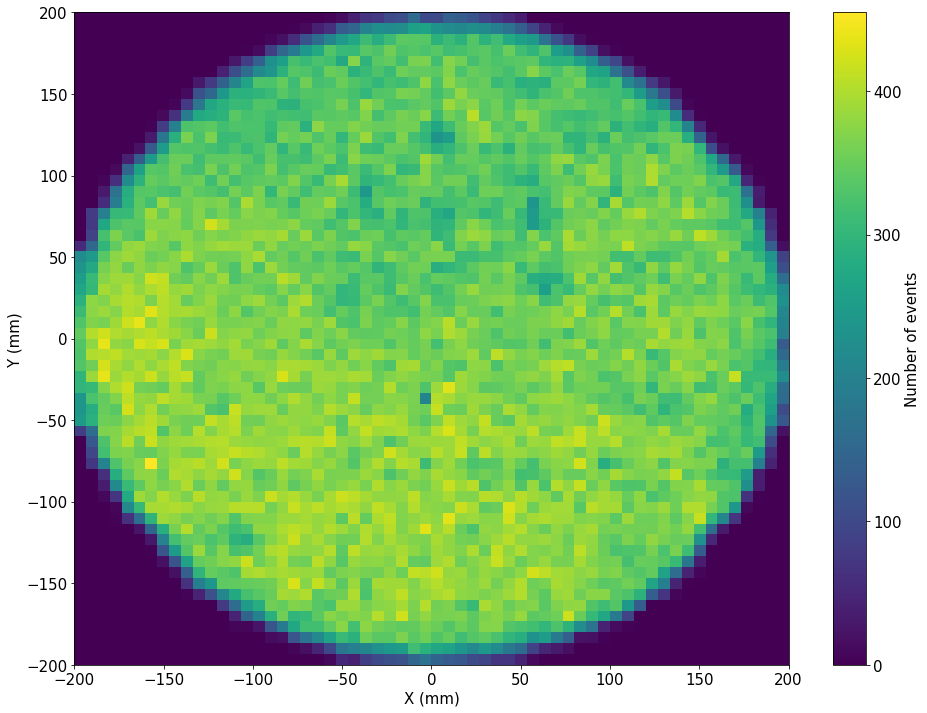

In [7]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")
save(f"EventDistribution_{XYpitch:.1f}mm_XY")

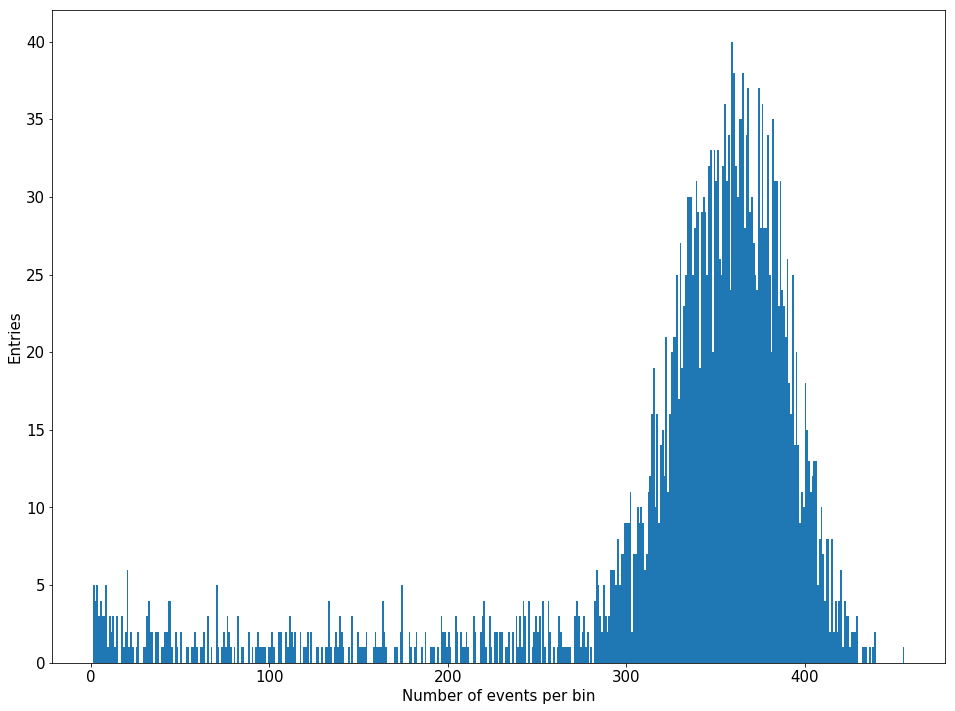

In [8]:
nevt_max = int(np.max(nevt))
plt.hist(nevt.flatten(), np.arange(1, nevt_max+2))
labels("Number of events per bin", "Entries", "# events per bin")
save(f"EventDistribution_{XYpitch:.1f}mm")

### Compute drift velocity map

In [25]:
from invisible_cities.evm  .ic_containers import Measurement
from invisible_cities.icaro.hst_functions import poisson_sigma

def fit_slices_2d_sigmoid(xdata, ydata, zdata,
                          xbins, ybins, zbins,
                          min_entries = 1e2):
    """
    Slice the data in x and y, histogram the z coordinate
    fit it to a sigmoid and return the relevant values.

    Parameters
    ----------
    xdata, ydata, zdata: array_likes
        Values of each coordinate.
    xbins, ybins, zbins: array_like
        The bins for each coordinate.
    min_entries: int (optional)
        Minimum amount of entries to perform the fit.

    Returns
    -------
    const: Measurement(np.ndarray, np.ndarray)
        Values of const with errors.
    slope: Measurement(np.ndarray, np.ndarray)
        Values of slope with errors.
    chi2: np.ndarray
        Chi2 from each fit.
    valid: boolean np.ndarray
        Where the fit has been succesfull.
    """
    sigmoid  = lambda x, A, B, C, D: A / (1 + np.exp((x - B) / C)) + D

    nbins_x = np.size (xbins) - 1
    nbins_y = np.size (ybins) - 1
    nbins   = nbins_x, nbins_y
    const   = np.zeros(nbins)
    drop    = np.zeros(nbins)
    scale   = np.zeros(nbins)
    offset  = np.zeros(nbins)
    constu  = np.zeros(nbins)
    dropu   = np.zeros(nbins)
    scaleu  = np.zeros(nbins)
    offsetu = np.zeros(nbins)
    chi2    = np.zeros(nbins)
    valid   = np.zeros(nbins, dtype=bool)

    for i in range(nbins_x):
        sel_x = in_range(xdata, *xbins[i:i + 2])
        for j in range(nbins_y):
            sel_y = in_range(ydata, *ybins[j:j + 2])
            sel   = sel_x & sel_y
            if np.count_nonzero(sel) < min_entries: continue

            try:
                y, x = np.histogram(zdata[sel])
                x    = shift_to_bin_centers(x)
                seed = np.max(y), 550, 10, np.min(y)
                f    = fitf.fit(sigmoid, x, y, seed, sigma=poisson_sigma(y), maxfev=10000)
                const [i, j], constu [i, j] = f.values[0], f.errors[0]
                drop  [i, j], dropu  [i, j] = f.values[1], f.errors[1]
                scale [i, j], scaleu [i, j] = f.values[2], f.errors[2]
                offset[i, j], offsetu[i, j] = f.values[3], f.errors[3]
                chi2  [i, j] = f.chi2
                valid [i, j] = True
            except:
                pass
    return (Measurement(const , constu ),
            Measurement(drop  , dropu  ),
            Measurement(scale , scaleu ),
            Measurement(offset, offsetu),
            chi2, valid)

In [26]:
const, drop,   \
scale, offset, \
chi2, ok       = fit_slices_2d_sigmoid(X, Y, Z, XYbins, XYbins, Zbins, min_entries=1e2)

dv        = 532 / drop.value
u_dv      =  dv / drop.value * drop.uncertainty

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


In [27]:
np.any(ok)

True

In [28]:
DV_mean  = np.nanmean(dv[ok])
DV_std   = np.nanstd (dv[ok])

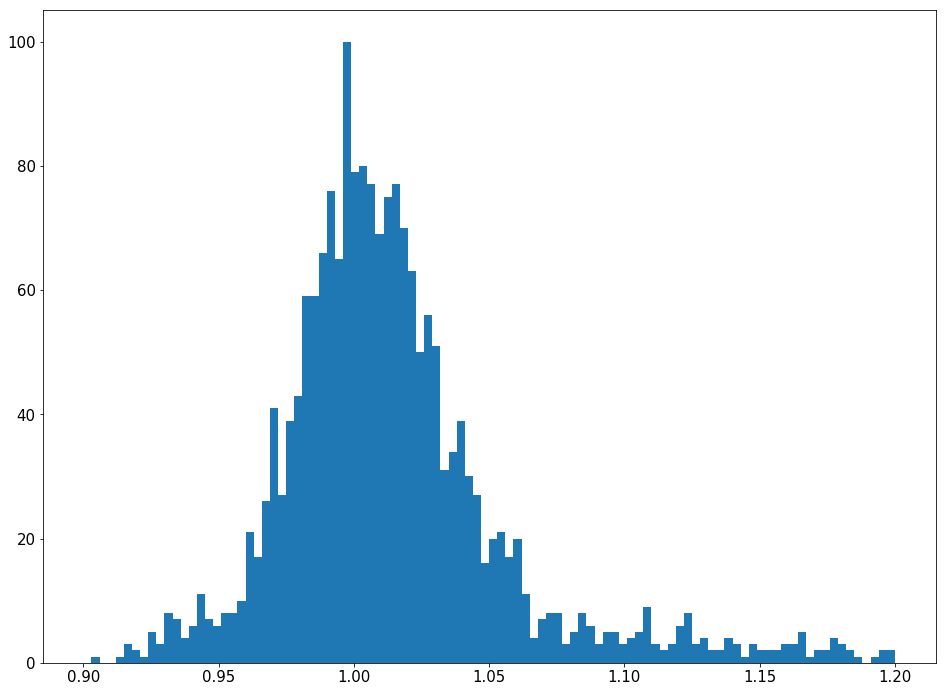

In [33]:
plt.hist(dv.flatten(), 100, (0.9, 1.2));

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


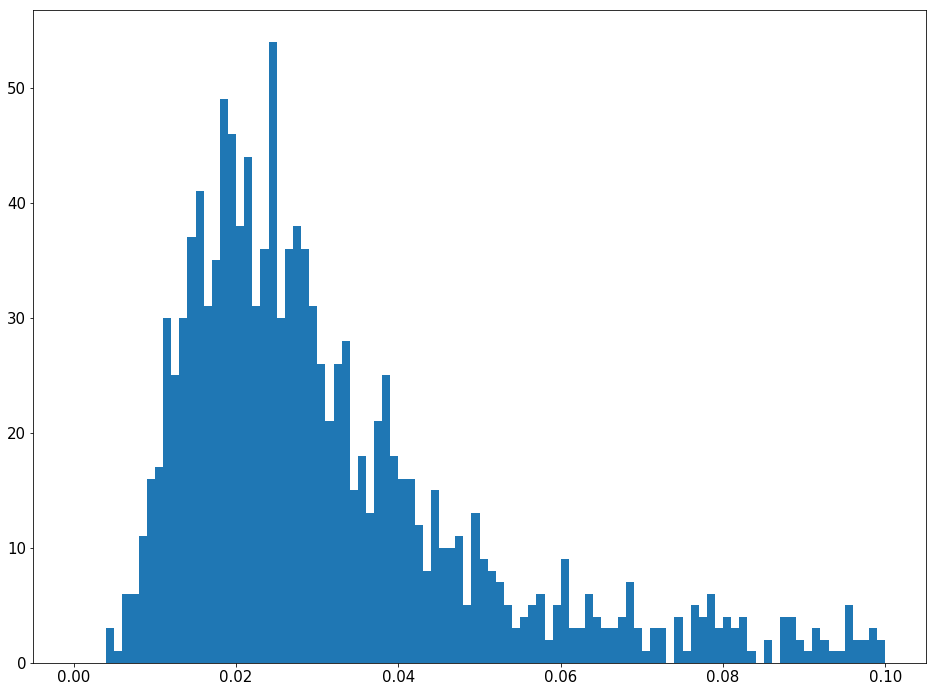

In [41]:
plt.hist(u_dv.flatten(), 100, (0, .1));

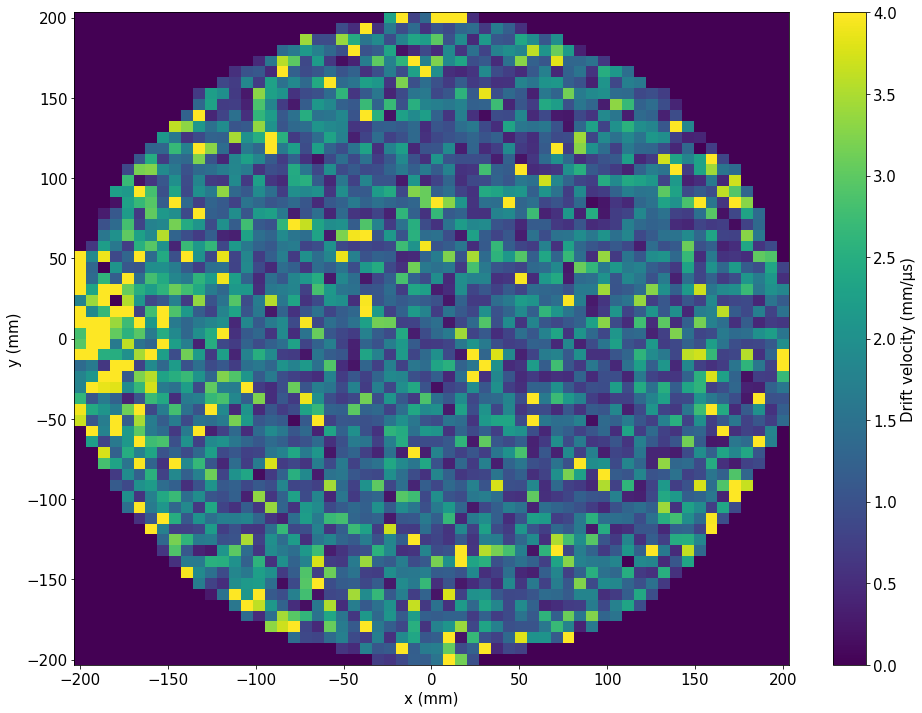

In [42]:
*_, cb = display_matrix(XYcenters, XYcenters, chi2, vmin = 0, vmax = 4)
cb.set_label("Drift velocity (mm/µs)")
labels("x (mm)", "y (mm)")

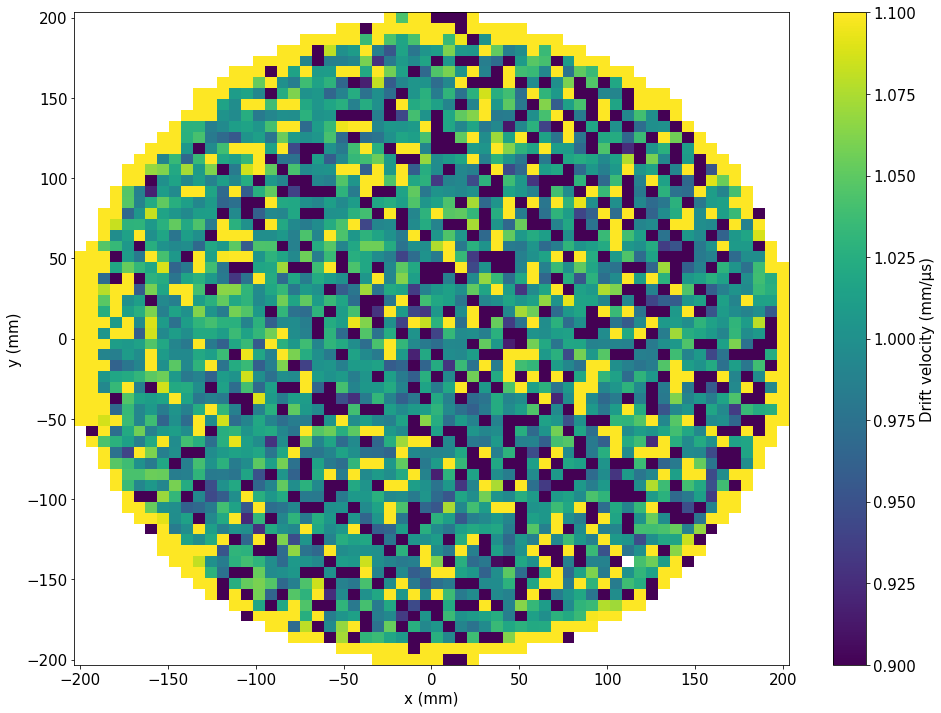

In [31]:
*_, cb = display_matrix(XYcenters, XYcenters, dv, vmin = 0.9, vmax = 1.1)
cb.set_label("Drift velocity (mm/µs)")
labels("x (mm)", "y (mm)")

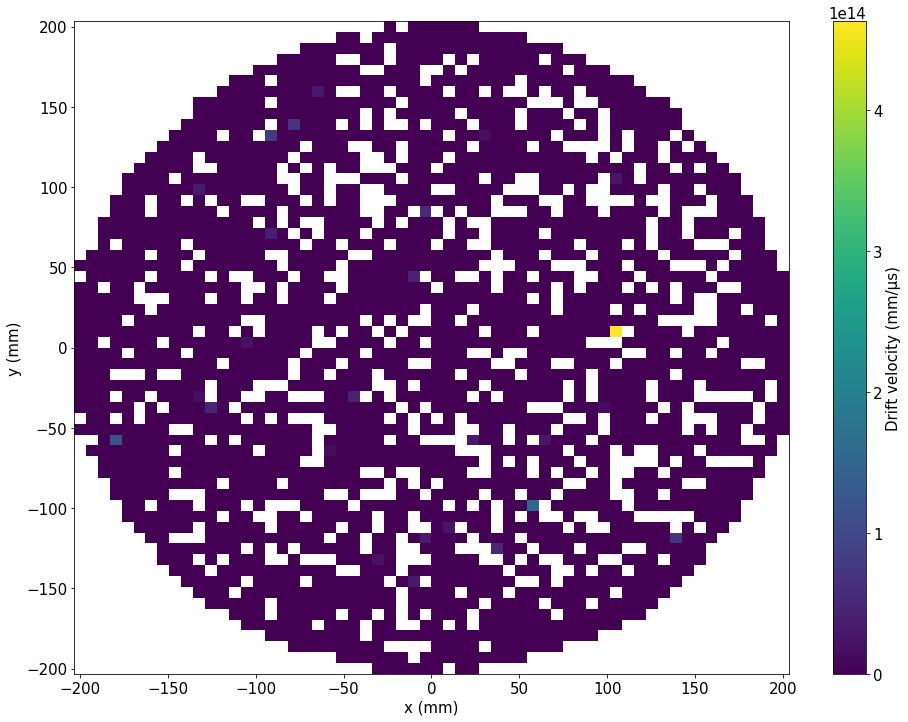

In [36]:
*_, cb = display_matrix(XYcenters, XYcenters, u_dv)
cb.set_label("Drift velocity (mm/µs)")
labels("x (mm)", "y (mm)")

In [9]:
LT_mean  = np.nanmean(LT    .value      [ok])
LT_std   = np.nanstd (LT    .value      [ok])
LTu_mean = np.nanmean(LT    .uncertainty[ok])
LTu_std  = np.nanstd (LT    .uncertainty[ok])

E_mean   = np.nanmean(Escale.value      [ok])
E_std    = np.nanstd (Escale.value      [ok])
Eu_mean  = np.nanmean(Escale.uncertainty[ok])
Eu_std   = np.nanstd (Escale.uncertainty[ok])

In [10]:
E_min   =       E_mean - 3.0 *   E_std
E_max   =       E_mean + 2.0 *   E_std

LT_min  =     -LT_mean - 4.0 *  LT_std
LT_max  =     -LT_mean + 3.0 *  LT_std

Eu_min  = max( Eu_mean - 1.5 *  Eu_std, 1e-3)
Eu_max  =      Eu_mean + 2.0 *  Eu_std

LTu_min = max(LTu_mean - 1.5 * LTu_std, 1e-3)
LTu_max =     LTu_mean + 2.0 * LTu_std

### Fit example

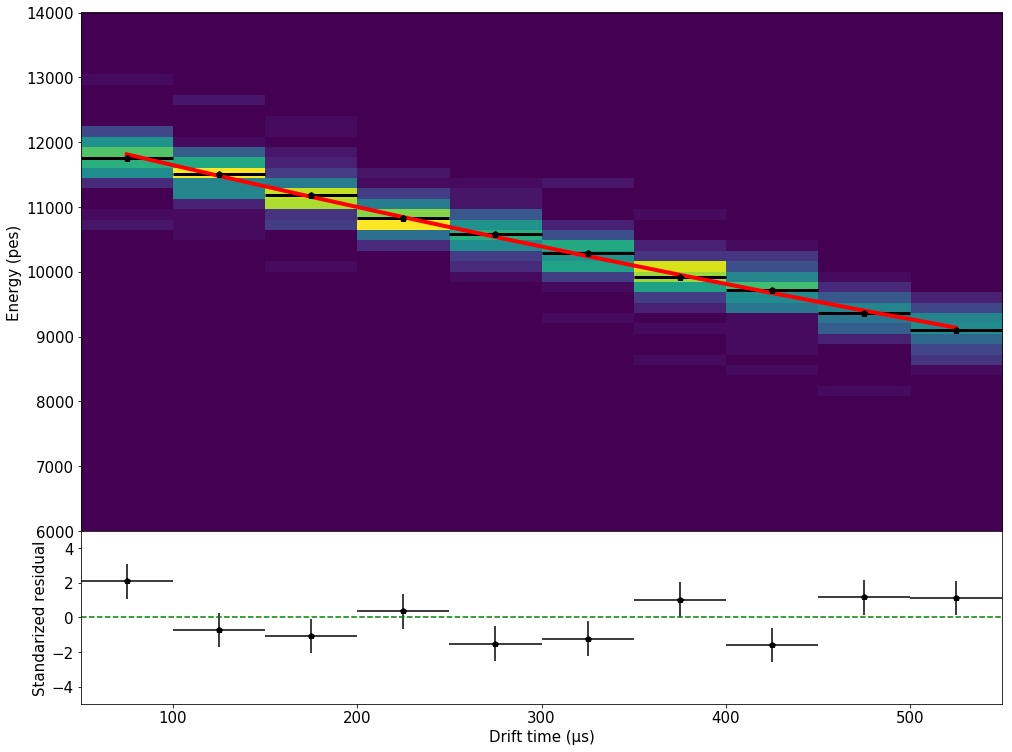

In [11]:
xlim =  15,  25
ylim = -25, -15
sel  = in_range(X, *xlim) & in_range(Y, *ylim)
z, e = Z[sel], E[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.hist2d(z, e, (Zbins, Ebins))

x, y, yu = fitf.profileX(z, e, Znbins, Zrange)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=7, lw=3)

seed = expo_seed(x, y)
f    = fitf.fit(fitf.expo, x, y, seed, sigma=yu)
plt.plot(x, f.fn(x), "r-", lw=4)

frame_data.set_xticklabels([])
labels("", "Energy (pes)", "Lifetime fit example")
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(x, (f.fn(x) - y) / yu, 1, np.diff(x)[0]/2, fmt="p", c="k")
plt.plot(lims, (0, 0), "g--")
plt.xlim(*lims)
plt.ylim(-5,+5)
labels("Drift time (µs)", "Standarized residual")

save("Lifetime_fit_example")

### Map display

Average lifetime             (mean +- rms) = (1763 +- 86) µs
Average lifetime uncertainty (mean +- rms) = (1.64 +- 0.23) (%)


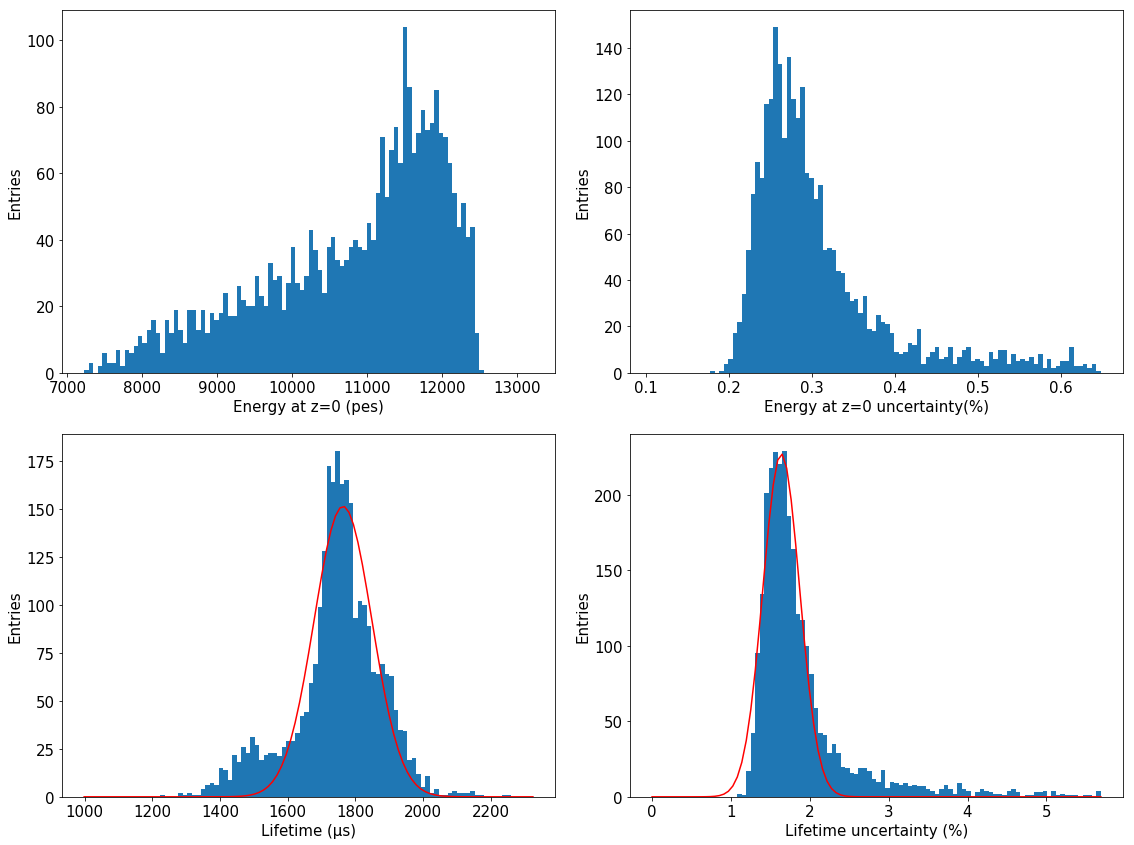

In [12]:
plt.subplot(2, 2, 1)
bins    = np.linspace(E_min, E_max, 101)
y, x, _ = plt.hist(Escale.value.flatten(), bins)
labels("Energy at z=0 (pes)", "Entries", "Energy scale distribution")

plt.subplot(2, 2, 2)
bins    = np.linspace(Eu_min, Eu_max, 101)
y, x, _ = plt.hist(Escale.uncertainty.flatten(), bins)
labels("Energy at z=0 uncertainty(%)", "Entries", "Energy scale uncertainty distribution")

plt.subplot(2, 2, 3)
bins    = np.linspace(LT_min, LT_max, 101)
y, x, _ = plt.hist       (-LT.value.flatten(), bins)
f       = quick_gauss_fit(-LT.value.flatten(), bins)
plt.plot(x, f.fn(x), "r-")
labels("Lifetime (µs)", "Entries", "Lifetime distribution")

plt.subplot(2, 2, 4)
bins    = np.linspace(LTu_min, LTu_max, 101)
y, x, _ = plt.hist       (LT.uncertainty.flatten(), bins)
fu      = quick_gauss_fit(LT.uncertainty.flatten(), bins)
plt.plot(x, fu.fn(x), "r-")
labels("Lifetime uncertainty (%)", "Entries", "Lifetime uncertainty distribution")

plt.tight_layout()

save("Lifetime_and_energy_scale_distributions")

print("Average lifetime             (mean +- rms) = ({}) µs" .format(measurement_string(f .values[1], f .values[2])))
print("Average lifetime uncertainty (mean +- rms) = ({}) (%)".format(measurement_string(fu.values[1], fu.values[2])))

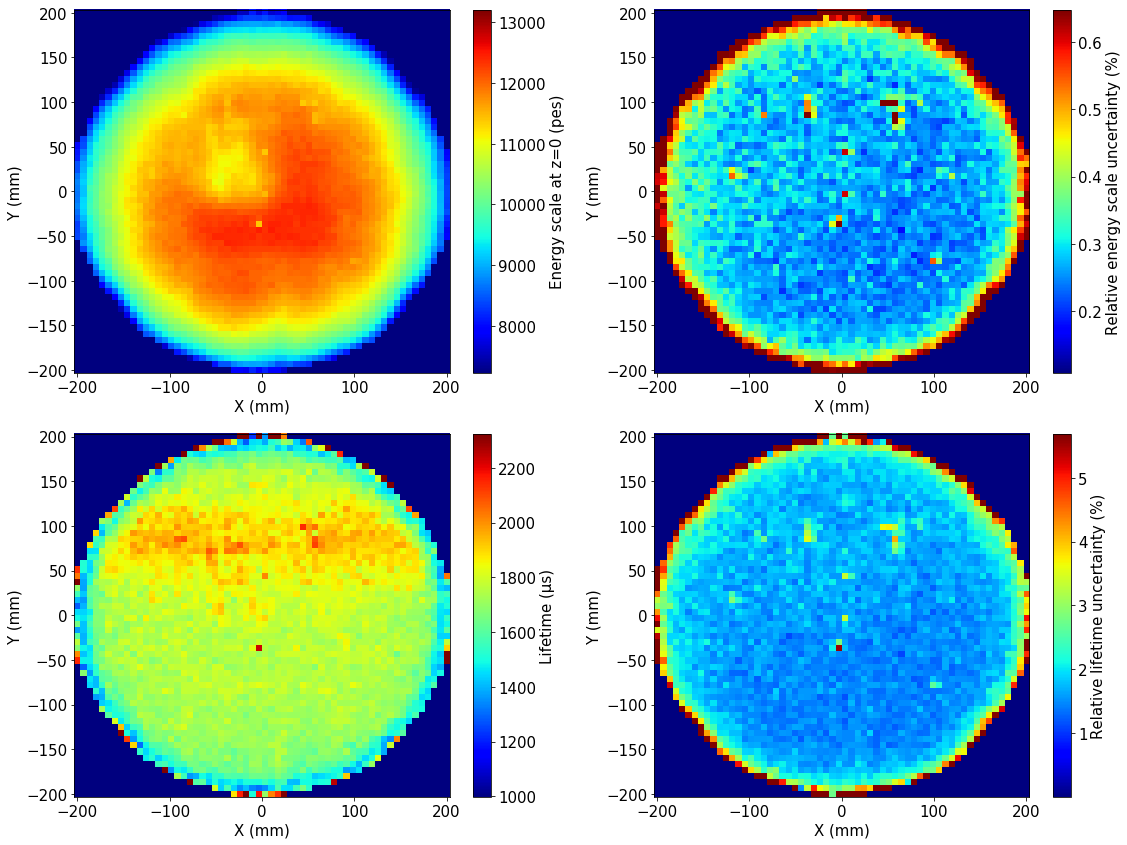

In [13]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Escale.value,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Energy scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Energy scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(XYcenters, XYcenters, Escale.uncertainty,
                        vmin = Eu_min,
                        vmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative energy scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(XYcenters, XYcenters, -LT.value,
                        vmin = LT_min,
                        vmax = LT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(XYcenters, XYcenters, LT.uncertainty,
                        vmin = LTu_min,
                        vmax = LTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()
save("Lifetime_and_energy_scale_maps")

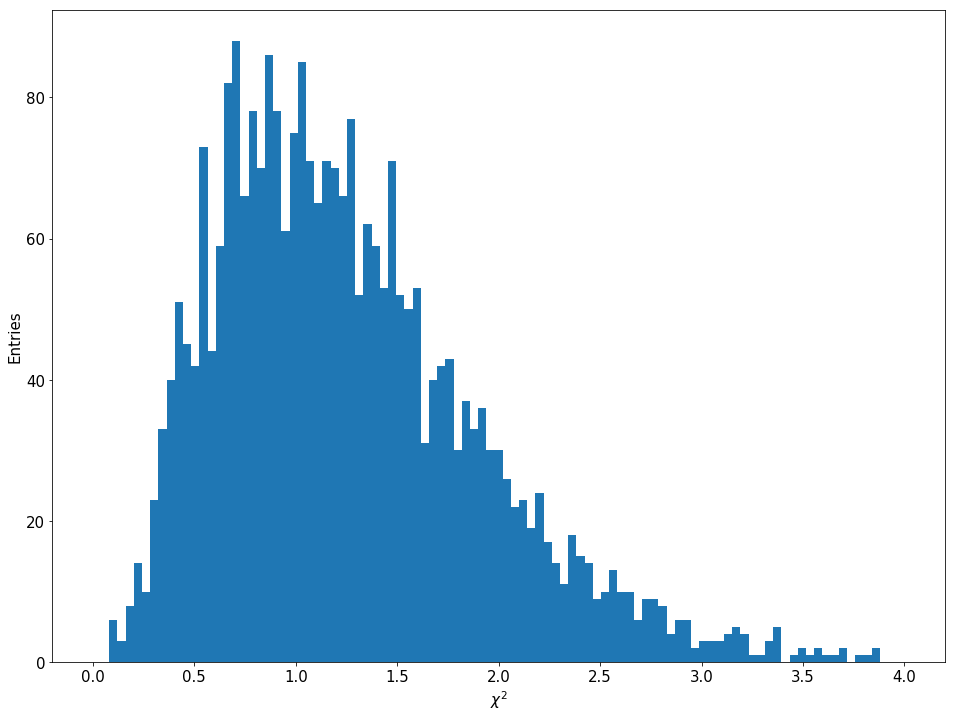

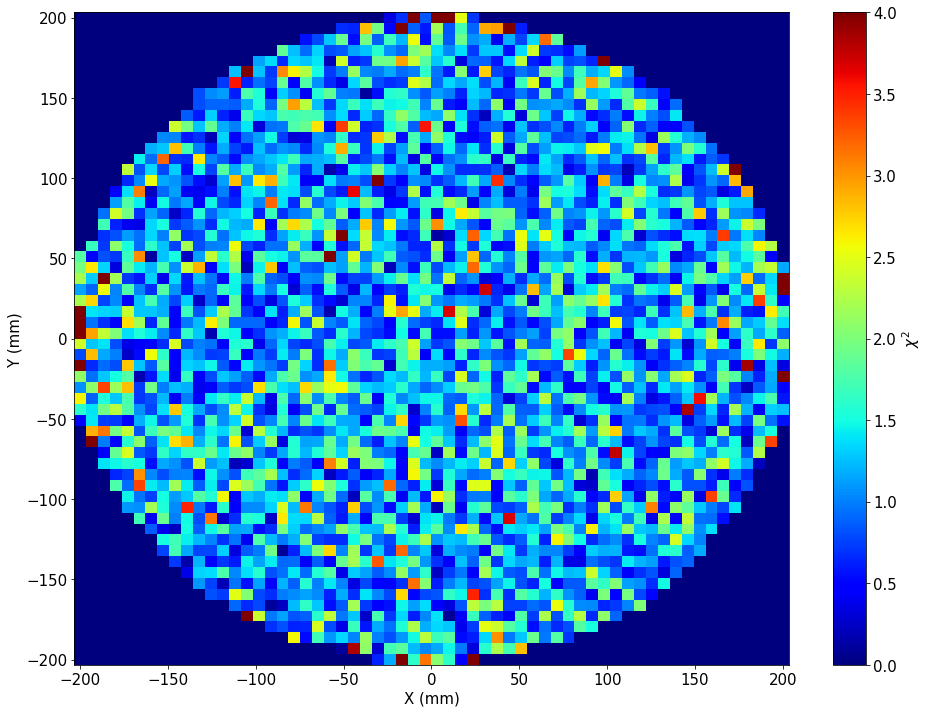

In [14]:
plt.hist(chi2[chi2 > 0], np.linspace(0, 4, 100))
labels("$\chi^2$", "Entries", "$\chi^2$ distribution")

*_, cb = display_matrix(XYcenters, XYcenters, chi2,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

### Produce HDF5 output

In [15]:
# This is to avoid the effect of low stat bins
# to the map. Data points in that bin could be
# loss or corrected with an unrealistic lifetime.
# Thus, we assign the average value. This works
# because correcting with a slightly different
# lifetime does not have a big impact on energy
# resolution.

Escale_safe  = np.where(ok, Escale_abs.value      ,    E_mean)
Escaleu_safe = np.where(ok, Escale_abs.uncertainty,   Eu_mean * E_mean / 100)

LT_safe      = np.where(ok,    -LT_abs.value      , - LT_mean)
LTu_safe     = np.where(ok,     LT_abs.uncertainty, -LTu_mean * LT_mean / 100)

with tb.open_file(correction_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_safe, Escaleu_safe, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, LT_safe, LTu_safe, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch